##### Aufgabe 1 -> training with IAM Sentences alone 
##### Aufgabe 1a -> training with IAM Sentences with GRU instead of LSTM  
##### Aufgabe 1b -> training with IAM Sentences with Efficientnet instead of LSTM
##### Aufgabe 2 -> training with a dataset of numbers only from BAFÖG 
##### Aufgabe 3 -> training with a dataset of numbers and words  from BAFÖG 
##### Aufgabe 4 -> training with a dataset of numbers and words and IAM dataset

In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras
from tensorflow.keras.layers import Input, Concatenate, Reshape, Bidirectional, LSTM, GRU, Dense,Conv2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

#### Aufgabe 1a and b

In [2]:
file_path ="C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/sentences.txt"
num_lines = 30

with open(file_path, "r") as file:
    for i in range(num_lines):
        line = file.readline()
        print(line.strip())


#--- sentences.txt -----------------------------------------------------------#
#
# iam database sentence information
#
# format: a01-000u-s0-00 0 ok 154 19 408 746 1663 91 A|MOVE|to|stop|Mr.|Gaitskell|from
#
#     a01-000u-s0-00  -> sentence/line id for form a01-000u
#     0               -> sentence number within this form
#     ok              -> result of word segmentation
#                            ok: line is correctly segmented
#                            er: segmentation of line has one or more errors
#
#                        warning: if a sentence starts or ends in the middle of
#                                 a line which is not correctly segmeted, a
#                                 correct extraction of the sentence can fail.
#
#     154             -> graylevel to binarize line
#     19              -> number of components for this part of the sentence
#     408 746 1663 91 -> bounding box around for this part of the sentence
#                        in the x,y,w,h 

#### Aufgabe 2 

In [42]:
file_path ="C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/sentences_kopie_2.txt"
num_lines = 30

with open(file_path, "r") as file:
    for i in range(num_lines):
        line = file.readline()
        print(line.strip())


#--- sentences_kopie_2.txt -----------------------------------------------------------#
#
#
# format: a01-000u-s0-00 0 ok 154 19 408 746 1663 91 A|MOVE|to|stop|Mr.|Gaitskell|from
#
#     z01-001-01  -> sentence/line id for form a01-000u
#     0               -> sentence number within this form
#     ok              -> result of word segmentation
#                            ok: line is correctly segmented
#                            er: segmentation of line has one or more errors
#
#                        warning: if a sentence starts or ends in the middle of
#                                 a line which is not correctly segmeted, a
#                                 correct extraction of the sentence can fail.
#
#     292             -> graylevel to binarize line
#     19              -> number of components for this part of the sentence
#     182 19 0 0 -> bounding box around for this part of the sentence
#z01-001 file , image z01-001-01,02,03,04.....
z01-001-01 0 ok 182 19 0 0 292

In [108]:
file_path ="C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/sentences_kopie_3.txt"
num_lines = 30

with open(file_path, "r") as file:
    for i in range(num_lines):
        line = file.readline()
        print(line.strip())


#--- sentences_kopie_3.txt -----------------------------------------------------------#
#
#
# format: a01-000u-s0-00 0 ok 154 19 408 746 1663 91 A|MOVE|to|stop|Mr.|Gaitskell|from
#
#     z01-001-01  -> sentence/line id for form a01-000u
#     0               -> sentence number within this form
#     ok              -> result of word segmentation
#                            ok: line is correctly segmented
#                            er: segmentation of line has one or more errors
#
#                        warning: if a sentence starts or ends in the middle of
#                                 a line which is not correctly segmeted, a
#                                 correct extraction of the sentence can fail.
#
#     292             -> graylevel to binarize line
#     19              -> number of components for this part of the sentence
#     182 19 0 0 -> bounding box around for this part of the sentence
#z01-001 file , image z01-001-01,02,03,04.....
z01-001-01 0 ok 182 19 0 0 292

In [111]:
base_path =  "C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data"
words_list = [] 

words = open(f"{base_path}/sentences.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [112]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 15076
Total validation samples: 838
Total test samples: 838


In [113]:
# string name for bafög number only is lines_3
# string name for senteces iAM number lines
# string name for senteces iAM number lines_4
base_image_path = os.path.join(base_path, "lines")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [114]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  93
Vocab size:  79


['spawning|herring|are|always|found|.',
 'whether|or|not|they|result|in|injury|.',
 '"|commit|suicide|"|at|the|TUC\'s',
 'She|nodded|:',
 'Adenauer|,|the|West|German|Chancellor|.',
 "The|committee's",
 'the|expected|but|not|easily|stimulated|development',
 'various|grounds|.',
 '"|It|is|very|questionable|whether',
 'robbery|,|and|this|was|further|confirmed|when|a']

In [115]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [116]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [117]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [118]:
batch_size = 64
padding_token = 99
image_width = 512
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [119]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

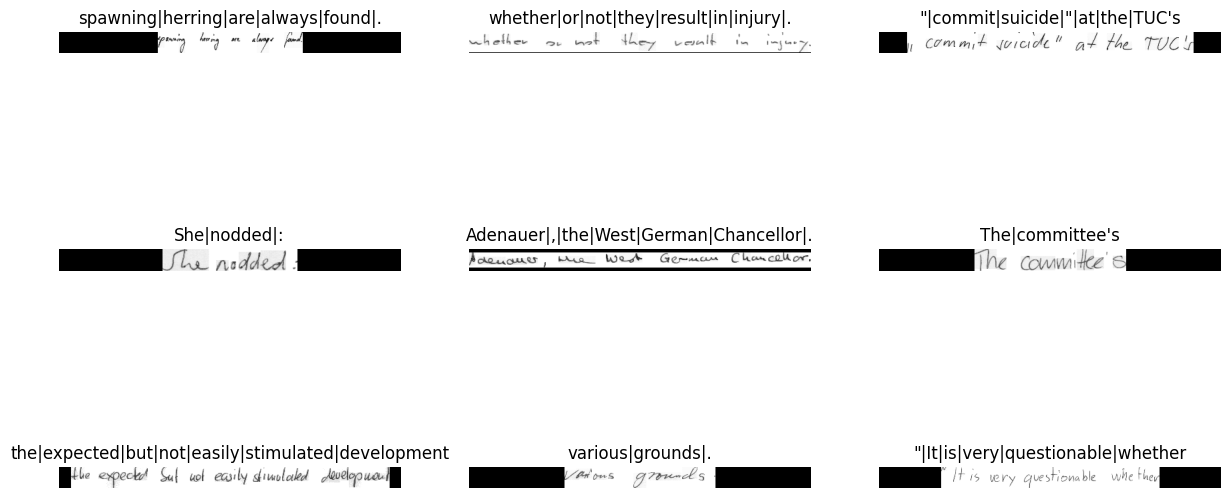

In [120]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(3, 3, figsize=(15, 8))  # Change 4, 4 to 3, 3

    for i in range(9):  # Change 16 to 9
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 3, i % 3].imshow(img, cmap="gray") 
        ax[i // 3, i % 3].set_title(label) 
        ax[i // 3, i % 3].axis("off") 

plt.show()


In [121]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [122]:

def build_model( rnn='lstm'):
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))
    
            # First conv block.
    x = keras.layers.Conv2D(
                32,
                (3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                padding="same",
                name="Conv1",
            )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
        
            # Second conv block.
    x = keras.layers.Conv2D(
                64,
                (3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                padding="same",
                name="Conv2",
            )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
        
           
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)
            

        # RNNs with GRU layers.
    # x = keras.layers.Bidirectional(
    #         keras.layers.GRU(128, return_sequences=True, dropout=0.25)
    #     )(x)
    # x = keras.layers.Bidirectional(
    #         keras.layers.GRU(64, return_sequences=True, dropout=0.25)
    #     )(x)

        # RNNs with GRU layers.
    x = keras.layers.Bidirectional(
            keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
        )(x)
    x = keras.layers.Bidirectional(
            keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
        )(x)
        
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model



In [123]:
# Build a model with Conv2D backbone and LSTM recurrent layer
model_1 = build_model()

# Build a model with Conv2D backbone and GRU recurrent layer
#model_3 = build_model( rnn='gru')



In [124]:
# Get the model.
model_1.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 512, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 512, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 256, 16, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 256, 16, 64)          18496     ['pool1[0][0]']               
                                                                             

In [125]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [126]:
def calculate_edit_distance(labels, predictions):

    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [127]:
epochs = 100  
initial_learning_rate = 0.001
base_path_weights =  base_path + '/model_weights' 

def train_model(model, checkpoint_path, initial_epoch):
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
    )
    
    lr_callback = keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch))

    prediction_model = keras.models.Model(
        model.get_layer(name="image").input, model.get_layer(name="dense2").output
    )
    edit_distance_callback = EditDistanceCallback(prediction_model)

    # Define early stopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',  
        patience=5,            
        restore_best_weights=True  
    )

    checkpoint_path = checkpoint_path
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        save_best_only=False,
        monitor='loss',  # You can use any metric you are interested in
        mode='auto',
        verbose=1,
    )
    
    # Train the model with the callbacks
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=epochs,
        initial_epoch=initial_epoch,  
        callbacks=[edit_distance_callback, early_stopping_callback, lr_callback, checkpoint_callback],
    )
    
    return history  


In [128]:
def plot_history(history):
    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.tight_layout()
    plt.show()


In [ ]:
checkpoint_path= base_path_weights + '/IAM_only_conv2d_LSTM.h5'
history_1 = train_model(model_1, checkpoint_path ,0)

Epoch 1/100
1/1 [==============================] - 3s 3s/step
Mean edit distance for epoch 1: 93.0000

Epoch 1: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\IAM_only_conv2d_LSTM.h5
236/236 [==============================] - 424s 2s/step - loss: 116.4317 - val_loss: 106.0705 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 79ms/step
Mean edit distance for epoch 2: 93.0000

Epoch 2: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\IAM_only_conv2d_LSTM.h5
236/236 [==============================] - 373s 2s/step - loss: 106.8376 - val_loss: 104.8856 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 103ms/step
Mean edit distance for epoch 3: 92.1715

Epoch 3: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\IAM_only_conv2d_LSTM.h5
236/236 [==============================] - 308s 1s/step - loss: 98.0494 - val_loss: 87.3180 - lr: 0.

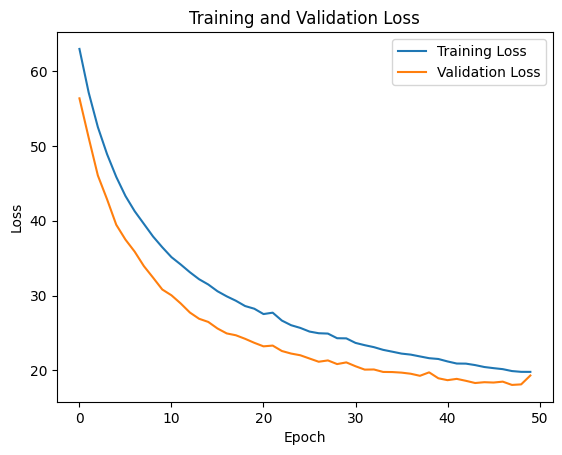

<Figure size 640x480 with 0 Axes>

In [31]:
# Plot the training and validation loss
plot_history(history_1)

In [102]:
checkpoint_path= base_path_weights + '/numbers_only_conv2d_LSTM.h5'
history_2 = train_model(model_1, checkpoint_path, 0)             

Epoch 1/100
1/1 [==============================] - 3s 3s/steploss: 292.77
Mean edit distance for epoch 1: 33.0000

Epoch 1: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\numbers_only_conv2d_LSTM.h5
5/5 [==============================] - 22s 2s/step - loss: 292.7753 - val_loss: 170.4095 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 110ms/steps: 105.92
Mean edit distance for epoch 2: 33.0000

Epoch 2: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\numbers_only_conv2d_LSTM.h5
5/5 [==============================] - 6s 1s/step - loss: 105.9282 - val_loss: 44.9518 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 110ms/steps: 65.89
Mean edit distance for epoch 3: 33.0000

Epoch 3: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\numbers_only_conv2d_LSTM.h5
5/5 [==============================] - 6s 1s/step - loss: 65.8994 - va

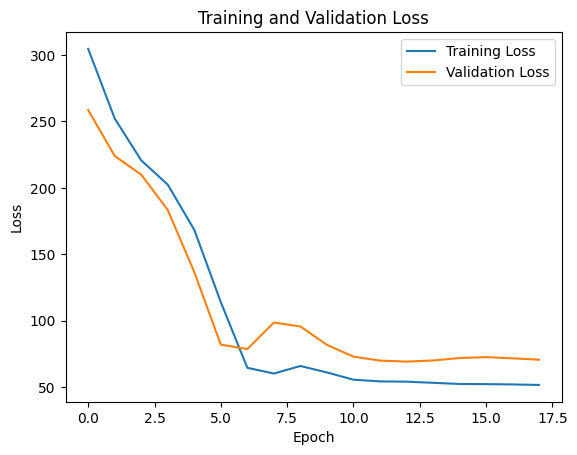

<Figure size 640x480 with 0 Axes>

In [134]:
# Plot the training and validation loss
plot_history(history_2)

In [24]:
checkpoint_path= base_path_weights + '/numbers_only_conv2d_GRU.h5'
history_3 = train_model(model_1, checkpoint_path, 0)

Epoch 1/50
1/1 [==============================] - 2s 2s/steploss: 279.13
Mean edit distance for epoch 1: 33.0000

Epoch 1: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\numbers_only_conv2d_LSTM.h5
5/5 [==============================] - 22s 3s/step - loss: 279.1302 - val_loss: 134.6089 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 156ms/steps: 98.57
Mean edit distance for epoch 2: 33.0000

Epoch 2: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\numbers_only_conv2d_LSTM.h5
5/5 [==============================] - 6s 1s/step - loss: 98.5756 - val_loss: 81.0169 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 126ms/steps: 73.31
Mean edit distance for epoch 3: 33.0000

Epoch 3: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\numbers_only_conv2d_LSTM.h5
5/5 [==============================] - 6s 1s/step - loss: 73.3195 - val_los

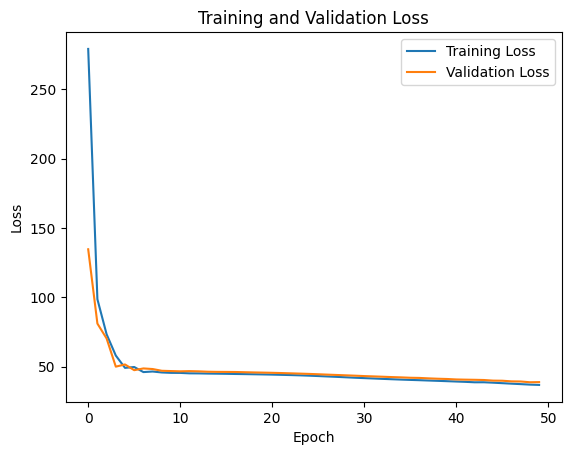

<Figure size 640x480 with 0 Axes>

In [25]:
# Plot the training and validation loss
plot_history(history_3)

In [82]:
checkpoint_path= base_path_weights + '/numbers_only_conv2d_LSTM.h5'
history_4 = train_model(model_1, checkpoint_path, 50)

Epoch 1/50
1/1 [==============================] - 2s 2s/steploss: 279.72
Mean edit distance for epoch 1: 33.0000

Epoch 1: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\numbers_only_conv2d_LSTM.h5
5/5 [==============================] - 19s 2s/step - loss: 279.7211 - val_loss: 205.3951 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 125ms/steps: 160.25
Mean edit distance for epoch 2: 33.0000

Epoch 2: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\numbers_only_conv2d_LSTM.h5
5/5 [==============================] - 6s 1s/step - loss: 160.2527 - val_loss: 59.0922 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 125ms/steps: 70.63
Mean edit distance for epoch 3: 33.0000

Epoch 3: saving model to C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/model_weights\numbers_only_conv2d_LSTM.h5
5/5 [==============================] - 5s 1s/step - loss: 70.6383 - val_l

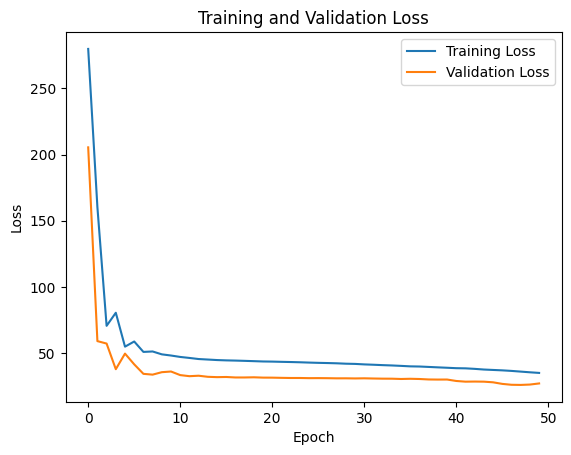

<Figure size 640x480 with 0 Axes>

In [83]:
plot_history(history_4)

In [84]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


def visualize_predictions(model):
    prediction_model = keras.models.Model(
        model.get_layer(name="image").input, model.get_layer(name="dense2").output
    )
    #  Let's check results on some test samples.
    for batch in train_ds.take(1):
        batch_images = batch["image"]
        num_images = batch_images.shape[0]
    
        # Calculate the number of rows and columns in the grid
        num_rows = 3
        num_cols = 3
    
        _, ax = plt.subplots(num_rows, num_cols, figsize=(15, 8))
    
        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)
    
        for i in range(min(num_rows * num_cols, num_images)):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]
    
            title = f"Prediction: {pred_texts[i]}"
            ax[i // num_cols, i % num_cols].imshow(img, cmap="gray")
            ax[i // num_cols, i % num_cols].set_title(title)
            ax[i // num_cols, i % num_cols].axis("off")
    
        # Hide empty subplots if there are fewer images than expected
        for j in range(num_images, num_rows * num_cols):
            ax[j // num_cols, j % num_cols].axis("off")
    
    plt.show()


2/2 [==============================] - 3s 218ms/step


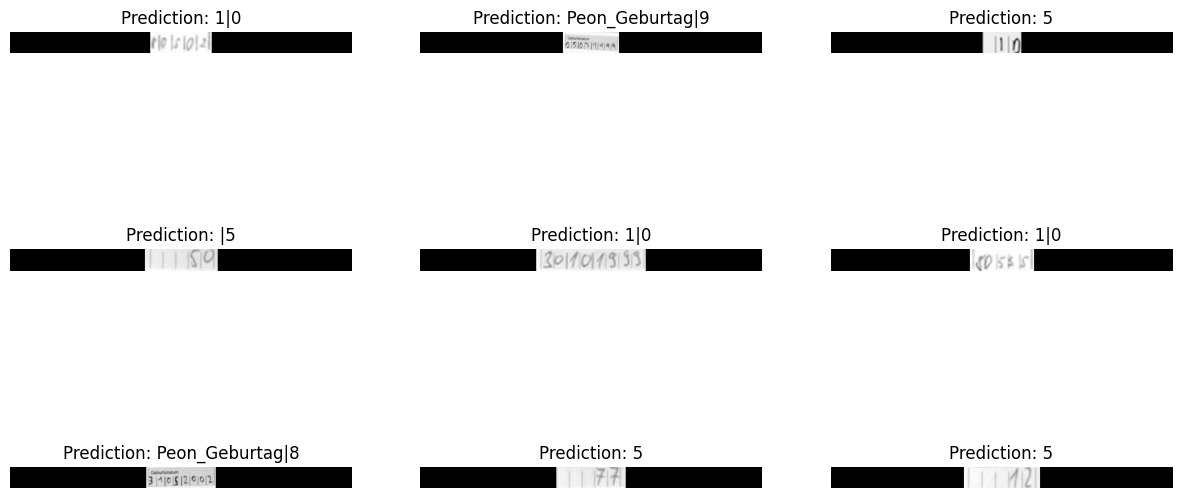

In [93]:
visualize_predictions(model_1)


2/2 [==============================] - 2s 176ms/step


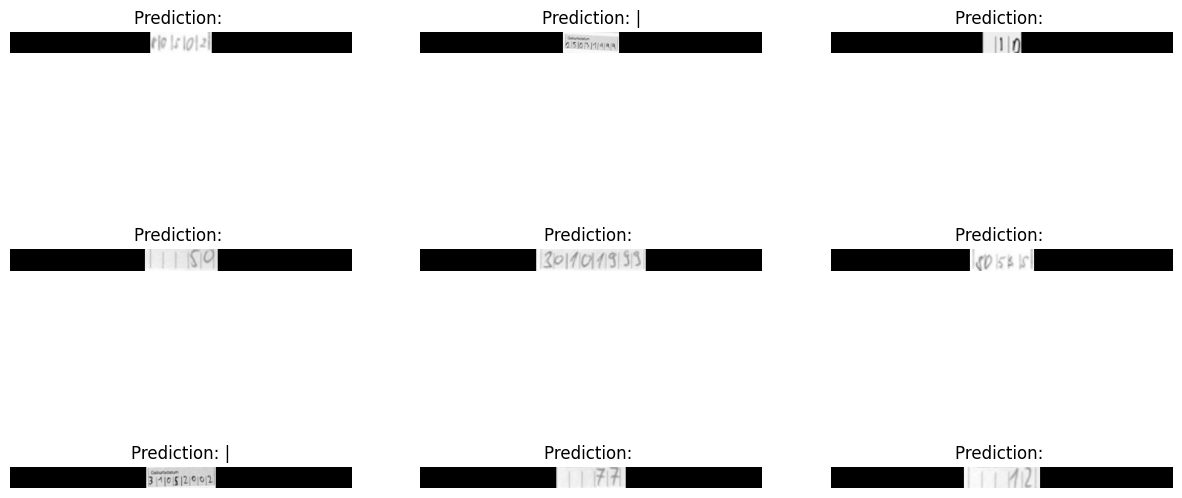

In [104]:
# Usage history_4 number only
visualize_predictions(model_1)

#### Transfer learning 

In [106]:

def build_model( rnn='lstm', pretrained_weights=None):
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))
    
            # First conv block.
    x = keras.layers.Conv2D(
                32,
                (3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                padding="same",
                name="Conv1",
            )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
        
            # Second conv block.
    x = keras.layers.Conv2D(
                64,
                (3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                padding="same",
                name="Conv2",
            )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
        
           
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)
            

        # RNNs with GRU layers.
    # x = keras.layers.Bidirectional(
    #         keras.layers.GRU(128, return_sequences=True, dropout=0.25)
    #     )(x)
    # x = keras.layers.Bidirectional(
    #         keras.layers.GRU(64, return_sequences=True, dropout=0.25)
    #     )(x)

        # RNNs with GRU layers.
    x = keras.layers.Bidirectional(
            keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
        )(x)
    x = keras.layers.Bidirectional(
            keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
        )(x)
        
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    model.load_weights(pretrained_weights)

    # Optimizer.
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model



In [107]:
checkpoint_path= base_path_weights + '/IAM_only_conv2d_LSTM.h5'
model = build_model(pretrained_weights=checkpoint_path)


ValueError: Invalid bias shape: (2, 384)